# EnKF Data Assimilation
Sequential FARSITE simulation with Ensemble Kalman Filter data assimilation.

This notebook runs FARSITE forward simulations and incorporates actual observations through EnKF at each timestep.

In [1]:
import sys
sys.path.insert(0, 'src')

import pandas as pd
import geopandas as gpd
import numpy as np
import json
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import requests
import time
from pyproj import Transformer
import contextily as ctx

from farsite import forward_pass_farsite, forward_pass_farsite_24h
from enkf import adjusted_state_EnKF_farsite
from geometry import geom_to_state, state_to_geom, align_states, plot_geometry
from config import OUTPUT_DIR, DATA_DIR, get_ensemble_size, DEFAULT_DIST_RES, DEFAULT_PERIM_RES, FIREMAP_WX_URL

## Helper Function: Dynamic Weather Queries

In [2]:
def query_weather_for_timestep(lat, lon, start_time, end_time, verbose=False):
    """
    Query weather data for a specific timestep.
    
    Args:
        lat: Latitude (WGS84)
        lon: Longitude (WGS84)
        start_time: Start datetime (pandas Timestamp)
        end_time: End datetime (pandas Timestamp)
        verbose: Print query details
        
    Returns:
        tuple: (wind_speed_list, wind_direction_list)
    """
    # Convert to ISO format
    start_iso = start_time.isoformat()
    end_iso = end_time.isoformat()
    
    if verbose:
        print(f"  Querying weather: {start_time} to {end_time}")
    
    # Query Firemap API
    timestamp = int(time.time() * 1000)
    wx_params = {
        'selection': 'closestTo',
        'lat': str(lat),
        'lon': str(lon),
        'observable': ['wind_speed', 'wind_direction'],
        'from': start_iso,
        'to': end_iso,
        'callback': 'wxData',
        '_': str(timestamp)
    }
    
    try:
        wx_response = requests.get(FIREMAP_WX_URL, params=wx_params, timeout=10)
        wx_text = wx_response.text.strip()
        
        # Remove JSONP wrapper
        if wx_text.startswith('wxData(') and wx_text.endswith(')'):
            wx_json = wx_text[len('wxData('):-1]
            wx_obs = json.loads(wx_json)
        else:
            wx_obs = wx_response.json()
        
        wind_speed_list = wx_obs["features"][0]["properties"]["wind_speed"]
        wind_direction_list = wx_obs["features"][0]["properties"]["wind_direction"]
        
        if verbose:
            print(f"  Retrieved {len(wind_speed_list)} observations")
            print(f"  Wind: {np.mean(wind_speed_list):.1f} mph @ {np.mean(wind_direction_list):.0f}°")
        
        return wind_speed_list, wind_direction_list
        
    except Exception as e:
        print(f"  WARNING: Weather query failed: {e}")
        print(f"  Using fallback values")
        # Return fallback values
        return [10.0], [225.0]  # Default 10 mph from SW

## 1. Load Configuration and Data

In [3]:
# Load workflow configuration
with open(DATA_DIR / "workflow_config.json", 'r') as f:
    workflow_config = json.load(f)

FIRE_NAME = workflow_config["fire_name"]
LCP_PATH = workflow_config["lcp_path"]
IGNITION_DATE = pd.Timestamp(workflow_config["ignition_date"])
CONTAINMENT_DATE = pd.Timestamp(workflow_config["containment_date"])
N_PERIMETERS = workflow_config["n_perimeters"]

print(f"Fire: {FIRE_NAME}")
print(f"Duration: {IGNITION_DATE.date()} to {CONTAINMENT_DATE.date()}")
print(f"Number of perimeter updates: {N_PERIMETERS}")
print(f"Landscape file: {LCP_PATH}")

Fire: BORDER 2
Duration: 2025-01-23 to 2025-01-26
Number of perimeter updates: 6
Landscape file: landscape.lcp


In [4]:
# Load perimeters — already sorted oldest→newest by fetch_fire_perimeters()
perimeters_gdf = gpd.read_file(
    OUTPUT_DIR / f"{FIRE_NAME.lower().replace(' ', '_')}_perimeters.geojson"
)
perimeters_gdf['datetime'] = pd.to_datetime(perimeters_gdf['datetime'])

print(f"Loaded {len(perimeters_gdf)} perimeters")
for i, row in perimeters_gdf.iterrows():
    print(f"  [{i}] {row['datetime']}  —  {row.geometry.area/1e6:.2f} km²")

Loaded 6 perimeters
  [0] 2025-01-23 00:00:00  —  2.29 km²
  [1] 2025-01-23 00:00:00  —  2.29 km²
  [2] 2025-01-23 00:00:00  —  2.29 km²
  [3] 2025-01-24 00:00:00  —  17.14 km²
  [4] 2025-01-24 00:00:00  —  25.33 km²
  [5] 2025-01-26 00:00:00  —  26.67 km²


In [5]:
# Load weather location from config
wx_lat = workflow_config["weather_location"]["lat"]
wx_lon = workflow_config["weather_location"]["lon"]

print(f"\nWeather query location: {wx_lat:.4f}, {wx_lon:.4f}")
print("Weather will be queried dynamically for each timestep")


Weather query location: 32.5959, -116.8571
Weather will be queried dynamically for each timestep


## 2. Configure Simulation Parameters

In [6]:
# FARSITE parameters
DIST_RES = DEFAULT_DIST_RES  # meters
PERIM_RES = DEFAULT_PERIM_RES  # meters
FARSITE_TIMESTEP = pd.Timedelta(minutes=30)

# EnKF parameters
VSIZE = 500  # Observation noise (meters)
WSIZE = 200  # Model noise (meters)
RANDOM_SEED = 1234

# Initialize random number generator
rng = np.random.Generator(np.random.PCG64(RANDOM_SEED))

print("Simulation Parameters:")
print(f"  FARSITE distance resolution: {DIST_RES} m")
print(f"  FARSITE perimeter resolution: {PERIM_RES} m")
print(f"  FARSITE timestep: {FARSITE_TIMESTEP}")
print(f"  Observation noise (vsize): {VSIZE} m")
print(f"  Model noise (wsize): {WSIZE} m")

Simulation Parameters:
  FARSITE distance resolution: 150 m
  FARSITE perimeter resolution: 150 m
  FARSITE timestep: 0 days 00:30:00
  Observation noise (vsize): 500 m
  Model noise (wsize): 200 m


## 3. Initialize Tracking Variables

In [7]:
# Storage for results
results = {
    'timestep': [],
    'datetime': [],
    'initial_geom': [],
    'observed_geom': [],
    'predicted_geom': [],
    'analysis_geom': [],
    'covariance': [],
    'n_vertices': [],
    'ensemble_size': [],
    'valid_ensemble_members': [],
    'mean_wind_speed': [],      # NEW: Track wind speed
    'mean_wind_direction': [],  # NEW: Track wind direction
    'n_weather_obs': []          # NEW: Number of weather observations
}

# Initialize state for first timestep
current_state = geom_to_state(perimeters_gdf['geometry'].iloc[0])
n_vertex = current_state.shape[0] // 2
X = 1000.0 * np.eye(2 * n_vertex)  # Initial covariance

print(f"Initial state:")
print(f"  Vertices: {n_vertex}")
print(f"  State dimension: {2 * n_vertex}")
print(f"  Covariance shape: {X.shape}")

Initial state:
  Vertices: 598
  State dimension: 1196
  Covariance shape: (1196, 1196)


## 4. Sequential Simulation Loop

**FARSITE → EnKF Feedback Loop:**

For each timestep (t → t+1):
1. **FARSITE Prediction**: Use current state (from previous EnKF analysis) as initial condition
2. **EnKF Assimilation**: Combine FARSITE prediction with actual observation
3. **Feedback**: EnKF analysis becomes the initial condition for next timestep

This creates a feedback loop where observations continuously correct the predictions.

In [8]:
# Main simulation loopn_timesteps = len(perimeters_gdf) - 1  # We predict from t to t+1print(f"Starting sequential simulation for {n_timesteps} timesteps...\n")print("="*80)for t in range(n_timesteps):    print(f"\n{'='*80}")    print(f"TIMESTEP {t} → {t+1}")    print(f"{'='*80}")        # Get current and next observation    current_obs = perimeters_gdf.iloc[t]    next_obs = perimeters_gdf.iloc[t + 1]        current_time = pd.Timestamp(current_obs['datetime'])    next_time = pd.Timestamp(next_obs['datetime'])    dt = next_time - current_time        print(f"Current time: {current_time}")    print(f"Next time: {next_time}")    print(f"Time delta: {dt}")        # Geometries    initial_geom = state_to_geom(current_state)    observed_geom = next_obs['geometry']        print(f"\nInitial perimeter area: {initial_geom.area / 1e6:.2f} km²")    print(f"Observed perimeter area: {observed_geom.area / 1e6:.2f} km²")        # ========================================================================    # STEP 1: FARSITE Forward Prediction    # ========================================================================    print(f"\n[1/2] Running FARSITE forward prediction...")        # Query weather for this specific timestep    try:        timestep_ws_list, timestep_wd_list = query_weather_for_timestep(            lat=wx_lat,            lon=wx_lon,            start_time=current_time,            end_time=next_time,            verbose=True        )        mean_ws = np.mean(timestep_ws_list)        mean_wd = np.mean(timestep_wd_list)    except Exception as e:        print(f"  Using fallback weather: {e}")        mean_ws = 10.0        mean_wd = 225.0        farsite_params = {        'windspeed': int(mean_ws),        'winddirection': int(mean_wd),        'dt': dt    }        predicted_geom = forward_pass_farsite_24h(        poly=initial_geom,        params=farsite_params,        start_time=current_time.strftime("%Y-%m-%d %H:%M:%S"),        lcppath=LCP_PATH, '_')}_t{t}",        dist_res=DIST_RES,        perim_res=PERIM_RES    )        if predicted_geom is None:        print(f"WARNING: FARSITE failed at timestep {t}. Skipping to next.")        continue        print(f"✓ FARSITE prediction complete")    print(f"  Predicted perimeter area: {predicted_geom.area / 1e6:.2f} km²")        # ========================================================================    # STEP 2: EnKF Data Assimilation    # ========================================================================    print(f"\n[2/2] Running EnKF data assimilation...")        # Prepare states    observation_state = geom_to_state(observed_geom)        # Align states to ensure consistent vertex count    n_vertex = current_state.shape[0] // 2    observation_state, current_state = align_states(        [observation_state, current_state],        vertex_count=n_vertex    )        # EnKF configuration    n_states = 2 * n_vertex    n_output = n_states    n_samples = get_ensemble_size(n_vertex)        print(f"  State dimension: {n_states}")    print(f"  Ensemble size: {n_samples}")        # Sample weather for ensemble from timestep-specific data    if len(timestep_ws_list) > 1:        idx = rng.integers(0, len(timestep_ws_list), size=n_samples)        sampled_wslst = np.asarray(timestep_ws_list)[idx]        sampled_wdlst = np.asarray(timestep_wd_list)[idx]    else:        # If only one observation, add noise around it        sampled_wslst = mean_ws + rng.normal(0, 2.0, size=n_samples)  # +/- 2 mph        sampled_wdlst = mean_wd + rng.normal(0, 15.0, size=n_samples)  # +/- 15 degrees        sampled_wslst = np.maximum(sampled_wslst, 0)  # Wind speed can't be negative        sampled_wdlst = np.fmod(sampled_wdlst + 360, 360)  # Keep in [0, 360)        # Run EnKF    try:        adjusted_state, X, zkphat, xkhat, ykhat, xkphat = adjusted_state_EnKF_farsite(            initial_state=current_state,            observation_state=observation_state,            observation_time=next_time,            X=X,            n_states=n_states,            n_output=n_output,            n_vertex=n_vertex,            n_samples=n_samples,            rng=rng,            sampled_wslst=sampled_wslst,            sampled_wdlst=sampled_wdlst,            dt=FARSITE_TIMESTEP,            vsize=VSIZE,            wsize=WSIZE, '_')}_enkf_t{t}",            dist_res=DIST_RES,            perim_res=PERIM_RES,            lcppath=LCP_PATH        )                analysis_geom = state_to_geom(adjusted_state)                # Count valid ensemble members (non-zero forecasts)        valid_members = np.sum(np.any(zkphat != 0, axis=0))                print(f"✓ EnKF complete")        print(f"  Valid ensemble members: {valid_members}/{n_samples}")        print(f"  Analysis perimeter area: {analysis_geom.area / 1e6:.2f} km²")            except Exception as e:        print(f"ERROR in EnKF at timestep {t}: {e}")        analysis_geom = observed_geom  # Fallback to observation        adjusted_state = observation_state        valid_members = 0        # ========================================================================    # STEP 3: Store Results    # ========================================================================    results['timestep'].append(t)    results['datetime'].append(next_time)    results['initial_geom'].append(initial_geom)    results['observed_geom'].append(observed_geom)    results['predicted_geom'].append(predicted_geom)    results['analysis_geom'].append(analysis_geom)    results['covariance'].append(X.copy())    results['n_vertices'].append(n_vertex)    results['ensemble_size'].append(n_samples)    results['valid_ensemble_members'].append(valid_members)        results['mean_wind_speed'].append(mean_ws)    results['mean_wind_direction'].append(mean_wd)    results['n_weather_obs'].append(len(timestep_ws_list))            # Update state for next iteration (use analysis as new initial condition)    current_state = adjusted_state        print(f"\n✓ Timestep {t} → {t+1} complete")print(f"\n{'='*80}")print(f"SIMULATION COMPLETE")print(f"{'='*80}")print(f"\nProcessed {len(results['timestep'])} timesteps successfully")

Starting sequential simulation for 5 timesteps...


TIMESTEP 0 → 1
Current time: 2025-01-23 00:00:00
Next time: 2025-01-23 00:00:00
Time delta: 0 days 00:00:00

Initial perimeter area: 2.29 km²
Observed perimeter area: 2.29 km²

[1/2] Running FARSITE forward prediction...
  Querying weather: 2025-01-23 00:00:00 to 2025-01-23 00:00:00
  Retrieved 1 observations
  Wind: 5.1 mph @ 69°
FARSITE outputs cleaned
✓ FARSITE prediction complete
  Predicted perimeter area: 2.29 km²

[2/2] Running EnKF data assimilation...
  State dimension: 1196
  Ensemble size: 300
Initial bounds: (-1932305.3382568695, 1270179.5881404441, -1930060.2692279008, 1271822.7343478587)
Observation bounds: (-1932305.3382568695, 1270179.5881404441, -1930060.2692279008, 1271822.7343478587)


Running ensemble: 100%|██████████| 300/300 [30:37<00:00,  6.13s/it]    


Valid samples: 300, Failed samples: 0
Calculating adjusted state (ensemble-space)
REACHED RETURN
✓ EnKF complete
  Valid ensemble members: 300/300
  Analysis perimeter area: 3.27 km²

✓ Timestep 0 → 1 complete

TIMESTEP 1 → 2
Current time: 2025-01-23 00:00:00
Next time: 2025-01-23 00:00:00
Time delta: 0 days 00:00:00

Initial perimeter area: 3.27 km²
Observed perimeter area: 2.29 km²

[1/2] Running FARSITE forward prediction...
  Querying weather: 2025-01-23 00:00:00 to 2025-01-23 00:00:00
  Retrieved 1 observations
  Wind: 5.1 mph @ 69°
FARSITE outputs cleaned
✓ FARSITE prediction complete
  Predicted perimeter area: 3.27 km²

[2/2] Running EnKF data assimilation...
  State dimension: 1196
  Ensemble size: 300
Initial bounds: (-1932423.089673359, 1270082.8332799918, -1929999.849908761, 1272098.2275168493)
Observation bounds: (-1932305.3382568695, 1270179.5881404441, -1930060.2692279008, 1271822.7343478587)


Running ensemble: 100%|██████████| 300/300 [13:18<00:00,  2.66s/it]


Valid samples: 300, Failed samples: 0
Calculating adjusted state (ensemble-space)
REACHED RETURN
✓ EnKF complete
  Valid ensemble members: 300/300
  Analysis perimeter area: 3.03 km²

✓ Timestep 1 → 2 complete

TIMESTEP 2 → 3
Current time: 2025-01-23 00:00:00
Next time: 2025-01-24 00:00:00
Time delta: 1 days 00:00:00

Initial perimeter area: 3.03 km²
Observed perimeter area: 17.14 km²

[1/2] Running FARSITE forward prediction...
  Querying weather: 2025-01-23 00:00:00 to 2025-01-24 00:00:00
  Retrieved 145 observations
  Wind: 6.3 mph @ 70°
1 days 00:00:00 remaining.
0 days 23:30:00 remaining.
0 days 23:00:00 remaining.
0 days 22:30:00 remaining.
0 days 22:00:00 remaining.
0 days 21:30:00 remaining.
0 days 21:00:00 remaining.
0 days 20:30:00 remaining.
0 days 20:00:00 remaining.
0 days 19:30:00 remaining.
0 days 19:00:00 remaining.
0 days 18:30:00 remaining.
0 days 18:00:00 remaining.
0 days 17:30:00 remaining.
0 days 17:00:00 remaining.
0 days 16:30:00 remaining.
0 days 16:00:00 remai

Running ensemble: 100%|██████████| 300/300 [14:47<00:00,  2.96s/it]


Valid samples: 300, Failed samples: 0
Calculating adjusted state (ensemble-space)
REACHED RETURN
✓ EnKF complete
  Valid ensemble members: 300/300
  Analysis perimeter area: 0.78 km²

✓ Timestep 2 → 3 complete

TIMESTEP 3 → 4
Current time: 2025-01-24 00:00:00
Next time: 2025-01-24 00:00:00
Time delta: 0 days 00:00:00

Initial perimeter area: 0.78 km²
Observed perimeter area: 25.33 km²

[1/2] Running FARSITE forward prediction...
  Querying weather: 2025-01-24 00:00:00 to 2025-01-24 00:00:00
  Retrieved 1 observations
  Wind: 11.4 mph @ 63°
FARSITE outputs cleaned
✓ FARSITE prediction complete
  Predicted perimeter area: 0.78 km²

[2/2] Running EnKF data assimilation...
  State dimension: 1196
  Ensemble size: 300
Initial bounds: (-1931963.8426132516, 1270376.838645722, -1930901.588451329, 1271475.128877712)
Observation bounds: (-1935879.9950026057, 1270174.732736183, -1929245.9052555563, 1276990.2159424606)


Running ensemble: 100%|██████████| 300/300 [57:06<00:00, 11.42s/it]


Valid samples: 300, Failed samples: 0
Calculating adjusted state (ensemble-space)
REACHED RETURN
✓ EnKF complete
  Valid ensemble members: 300/300
  Analysis perimeter area: 0.17 km²

✓ Timestep 3 → 4 complete

TIMESTEP 4 → 5
Current time: 2025-01-24 00:00:00
Next time: 2025-01-26 00:00:00
Time delta: 2 days 00:00:00

Initial perimeter area: 0.17 km²
Observed perimeter area: 26.67 km²

[1/2] Running FARSITE forward prediction...
  Querying weather: 2025-01-24 00:00:00 to 2025-01-26 00:00:00
  Retrieved 253 observations
  Wind: 6.4 mph @ 127°
2 days 00:00:00 remaining.
1 days 23:30:00 remaining.
1 days 23:00:00 remaining.
1 days 22:30:00 remaining.
1 days 22:00:00 remaining.
1 days 21:30:00 remaining.
1 days 21:00:00 remaining.
1 days 20:30:00 remaining.
1 days 20:00:00 remaining.
1 days 19:30:00 remaining.
1 days 19:00:00 remaining.
1 days 18:30:00 remaining.
1 days 18:00:00 remaining.
1 days 17:30:00 remaining.
1 days 17:00:00 remaining.
1 days 16:30:00 remaining.
1 days 16:00:00 rema

## 5. Visualize Results

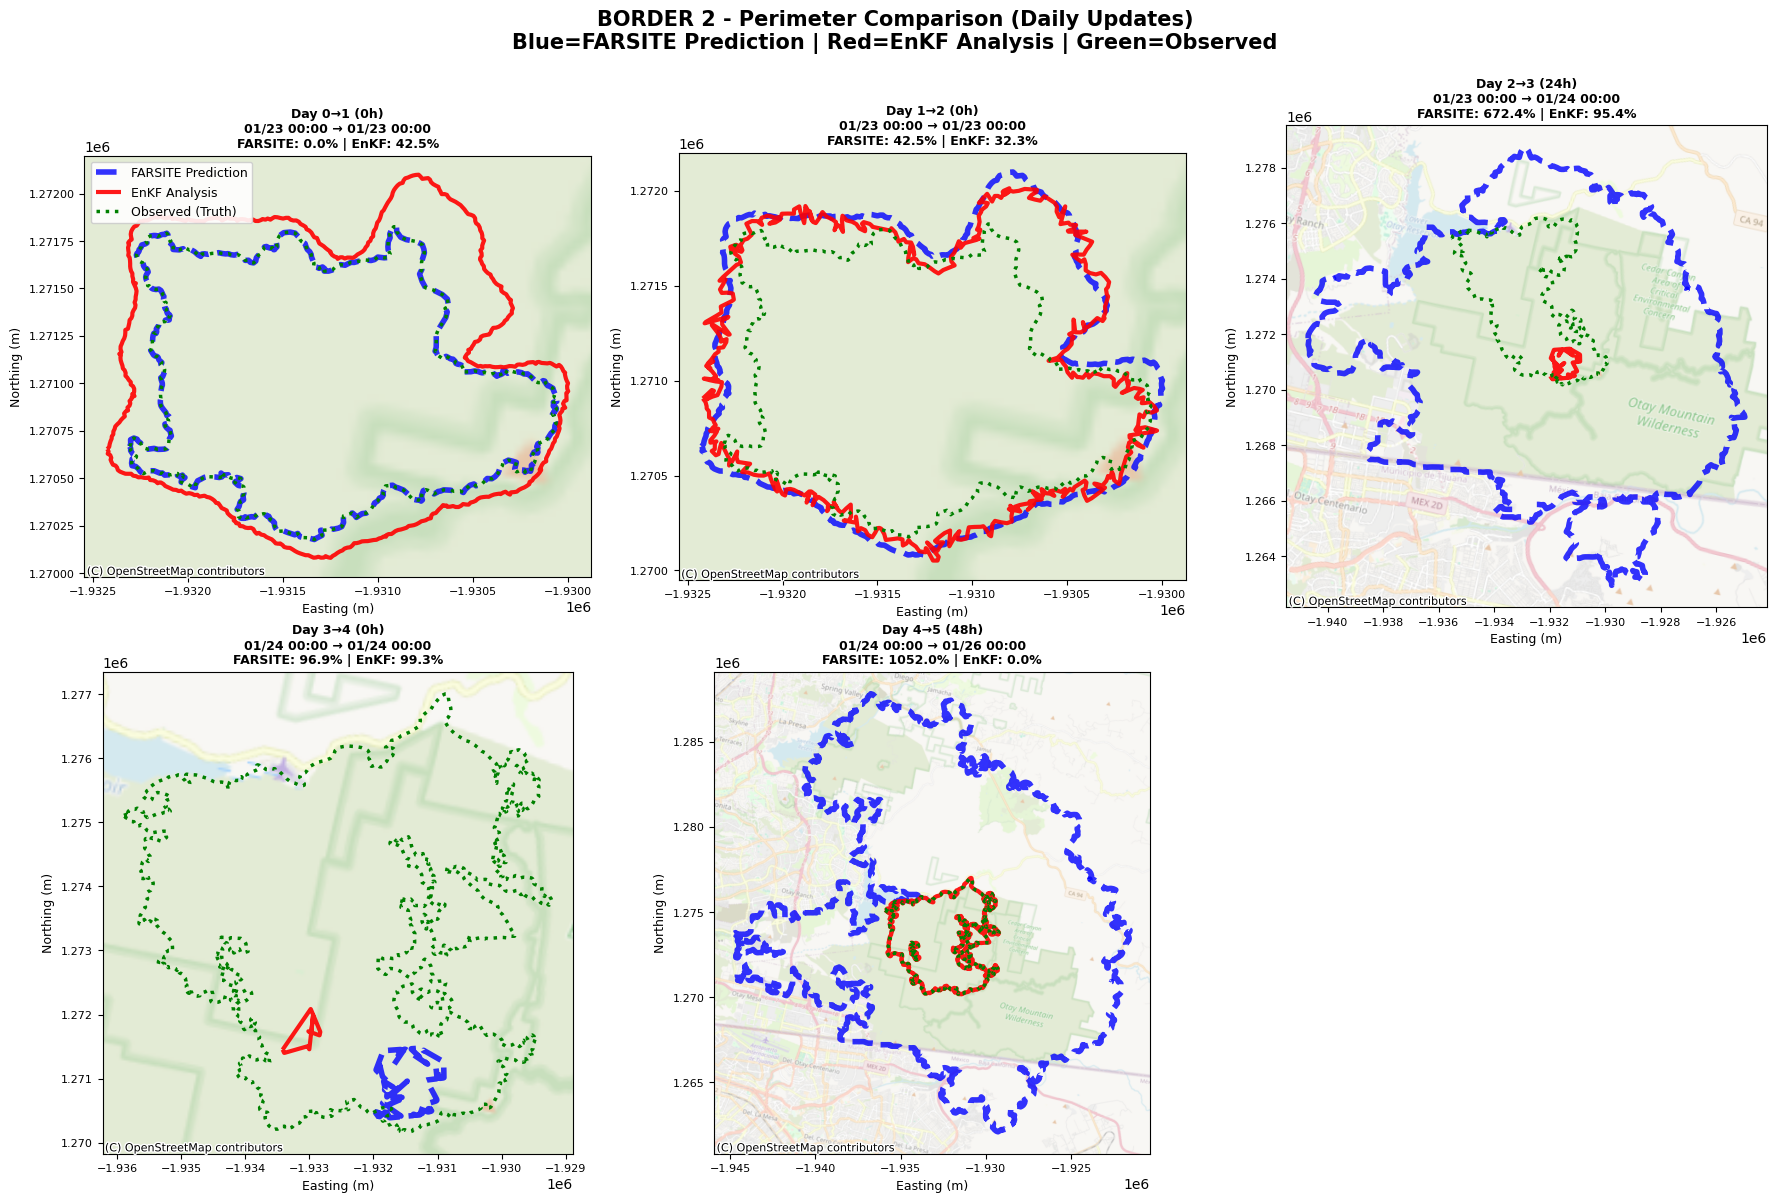


Fire Area and Error Summary
Timestep | Observed | FARSITE  | EnKF     | FARSITE Err | EnKF Err
──────────────────────────────────────────────────────────────────────
  0→1    |   2.29   |   2.29   |   3.27   |    0.0%     |   42.5%
  1→2    |   2.29   |   3.27   |   3.03   |   42.5%     |   32.3%
  2→3    |  17.14   | 132.38   |   0.78   |  672.4%     |   95.4%
  3→4    |  25.33   |   0.78   |   0.17   |   96.9%     |   99.3%
  4→5    |  26.67   | 307.26   |  26.67   | 1052.0%     |    0.0%


In [9]:
# Map visualization: Compare perimeters at each timestep
import contextily as ctx

n_timesteps = len(results['timestep'])
n_cols = 3
n_rows = (n_timesteps + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6*n_rows))
axes = axes.flatten() if n_timesteps > 1 else [axes]

for idx, t in enumerate(results['timestep']):
    ax = axes[idx]
    
    # Create GeoDataFrames for plotting
    pred_gdf = gpd.GeoDataFrame([1], geometry=[results['predicted_geom'][idx]], crs="EPSG:5070")
    analysis_gdf = gpd.GeoDataFrame([1], geometry=[results['analysis_geom'][idx]], crs="EPSG:5070")
    obs_gdf = gpd.GeoDataFrame([1], geometry=[results['observed_geom'][idx]], crs="EPSG:5070")
    
    # Plot in order: FARSITE → EnKF → Observed
    pred_gdf.boundary.plot(ax=ax, color='blue', linewidth=4, linestyle='--', 
                          label='FARSITE Prediction', zorder=2, alpha=0.8)
    analysis_gdf.boundary.plot(ax=ax, color='red', linewidth=3, linestyle='-', 
                              label='EnKF Analysis', zorder=3, alpha=0.9)
    obs_gdf.boundary.plot(ax=ax, color='green', linewidth=2.5, linestyle=':', 
                         label='Observed (Truth)', zorder=4)
    
    # Add basemap with explicit zoom level
    try:
        ctx.add_basemap(
            ax=ax, 
            source=ctx.providers.OpenStreetMap.Mapnik, 
            crs="EPSG:5070",
            zoom=12,
            alpha=0.5,
            zorder=1
        )
    except Exception as e:
        print(f"Could not add basemap for timestep {t}: {e}")
    
    # Format
    ax.set_aspect('equal')
    
    # Get start and end dates
    start_date = perimeters_gdf.iloc[t]['datetime']
    end_date = results["datetime"][idx]
    time_diff = (end_date - start_date).total_seconds() / 3600
    
    # Calculate error statistics
    obs_area = results['observed_geom'][idx].area / 1e6
    pred_area = results['predicted_geom'][idx].area / 1e6
    enkf_area = results['analysis_geom'][idx].area / 1e6
    farsite_err = abs(pred_area - obs_area) / obs_area * 100
    enkf_err = abs(enkf_area - obs_area) / obs_area * 100
    
    ax.set_title(
        f'Day {t}→{t+1} ({time_diff:.0f}h)\n' +
        f'{start_date.strftime("%m/%d %H:%M")} → {end_date.strftime("%m/%d %H:%M")}\n' +
        f'FARSITE: {farsite_err:.1f}% | EnKF: {enkf_err:.1f}%',
        fontsize=9, weight='bold'
    )
    
    if idx == 0:
        ax.legend(loc='upper left', fontsize=9, framealpha=0.9)
    
    ax.set_xlabel('Easting (m)', fontsize=9)
    ax.set_ylabel('Northing (m)', fontsize=9)
    ax.tick_params(labelsize=8)

# Hide unused subplots
for idx in range(n_timesteps, len(axes)):
    axes[idx].set_visible(False)

plt.suptitle(f'{FIRE_NAME} - Perimeter Comparison (Daily Updates)\n' +
            'Blue=FARSITE Prediction | Red=EnKF Analysis | Green=Observed', 
            fontsize=15, weight='bold', y=0.998)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / f"{FIRE_NAME.lower().replace(' ', '_')}_perimeter_maps.png", 
           dpi=200, bbox_inches='tight')
plt.show()

# Summary table
print(f"\n{'='*70}")
print(f"Fire Area and Error Summary")
print(f"{'='*70}")
print(f"Timestep | Observed | FARSITE  | EnKF     | FARSITE Err | EnKF Err")
print(f"{'─'*70}")
for idx, t in enumerate(results['timestep']):
    obs_area = results['observed_geom'][idx].area / 1e6
    pred_area = results['predicted_geom'][idx].area / 1e6
    enkf_area = results['analysis_geom'][idx].area / 1e6
    farsite_err = abs(pred_area - obs_area) / obs_area * 100
    enkf_err = abs(enkf_area - obs_area) / obs_area * 100
    print(f"  {t}→{t+1}    | {obs_area:6.2f}   | {pred_area:6.2f}   | {enkf_area:6.2f}   | "
          f"{farsite_err:6.1f}%     | {enkf_err:6.1f}%")
print(f"{'='*70}")

## 6. Save Results

In [10]:
# Create results GeoDataFrame
results_gdf = gpd.GeoDataFrame({
    'timestep': results['timestep'],
    'datetime': results['datetime'],
    'type': ['analysis'] * len(results['timestep']),
    'geometry': results['analysis_geom'],
    'area_km2': [g.area / 1e6 for g in results['analysis_geom']],
    'n_vertices': results['n_vertices'],
    'ensemble_size': results['ensemble_size'],
    'valid_members': results['valid_ensemble_members']
}, crs="EPSG:5070")

# Save analysis results
output_path = OUTPUT_DIR / f"{FIRE_NAME.lower().replace(' ', '_')}_sequential_analysis.geojson"
results_gdf.to_file(output_path, driver="GeoJSON")
print(f"✓ Analysis results saved to {output_path}")

✓ Analysis results saved to /home/jovyan/work/WIFIRE-Digital-Twinners/dt-refactored/outputs/border_2_sequential_analysis.geojson


In [11]:
# Save final state for potential continuation
from enkf import save_enkf_state

if len(results['timestep']) > 0:
    final_state_path = OUTPUT_DIR / f"{FIRE_NAME.lower().replace(' ', '_')}_final_state.npz"
    save_enkf_state(
        final_state_path,
        current_state,
        current_state,  # Use current as both initial and adjusted
        X,
        zkphat if 'zkphat' in locals() else np.array([]),
        xkhat if 'xkhat' in locals() else np.array([]),
        ykhat if 'ykhat' in locals() else np.array([]),
        xkphat if 'xkphat' in locals() else np.array([]),
        rng
    )
    print(f"✓ Final state saved to {final_state_path}")

EnKF state saved to /home/jovyan/work/WIFIRE-Digital-Twinners/dt-refactored/outputs/border_2_final_state.npz
✓ Final state saved to /home/jovyan/work/WIFIRE-Digital-Twinners/dt-refactored/outputs/border_2_final_state.npz


In [12]:
# Summary statistics
print("\n" + "="*80)
print("ANALYSIS SUMMARY")
print("="*80)
print(f"\nFire: {FIRE_NAME}")
print(f"Timesteps processed: {len(results['timestep'])}")
print(f"\nArea evolution:")
print(f"  Initial: {results['initial_geom'][0].area / 1e6:.2f} km²")
print(f"  Final (observed): {results['observed_geom'][-1].area / 1e6:.2f} km²")
print(f"  Final (FARSITE prediction): {results['predicted_geom'][-1].area / 1e6:.2f} km²")
print(f"  Final (EnKF analysis): {results['analysis_geom'][-1].area / 1e6:.2f} km²")
print(f"\nEnsemble performance:")
print(f"  Mean success rate: {np.mean(success_rate):.1f}%")
print(f"  Mean ensemble size: {np.mean(results['ensemble_size']):.0f}")
print(f"\nOutput files:")
print(f"  - {output_path.name}")
print(f"  - {final_state_path.name}")
print(f"  - Area evolution plot")
print(f"  - Spatial evolution plot")
print(f"  - Ensemble statistics plot")


ANALYSIS SUMMARY

Fire: BORDER 2
Timesteps processed: 5

Area evolution:
  Initial: 2.29 km²
  Final (observed): 26.67 km²
  Final (FARSITE prediction): 307.26 km²
  Final (EnKF analysis): 26.67 km²

Ensemble performance:


NameError: name 'success_rate' is not defined